In [22]:
%matplotlib notebook
import matplotlib.pyplot as plt
import math
import importlib
import pandas
import cv2
import quaternion
import sklearn.svm as svm
from sklearn.metrics import r2_score, mean_squared_error
from sklearn.externals import joblib
import numpy as np
from speed_regression import training_data as td
from algorithms import geometry

from scipy.ndimage.filters import gaussian_filter1d
nano_to_sec = 1e09

# configure the size of plot
fig_size = plt.rcParams['figure.figsize']
fig_size[0] = 12
fig_size[1] = 9

## Test: align with gravity

<IPython.core.display.Javascript object>


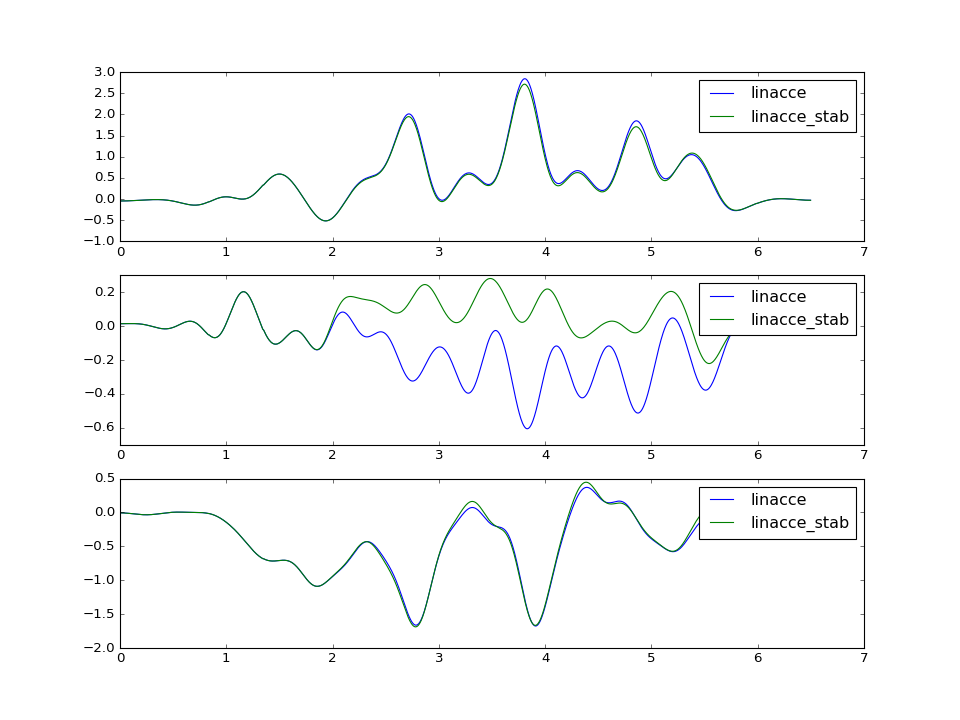

In [4]:
data_all = pandas.read_csv('../../data/test_gravity/gravity_rotate5/processed/data.csv')

ts = data_all['time'].values / nano_to_sec
ts -= ts[0]

linacce = data_all[['linacce_x', 'linacce_y', 'linacce_z']].values
linacce_stab = data_all[['linacce_stab_x', 'linacce_stab_y', 'linacce_stab_z']].values
gyro_stab = data_all[['gyro_stab_x', 'gyro_stab_y', 'gyro_stab_z']].values
gyro = data_all[['gyro_x', 'gyro_y', 'gyro_z']].values
gravity = data_all[['grav_x', 'grav_y', 'grav_z']].values
filter_sigma = 30.0

linacce = gaussian_filter1d(linacce, sigma=filter_sigma, axis=0)
linacce_stab = gaussian_filter1d(linacce_stab, sigma=filter_sigma, axis=0)

plt.figure('Stabilized linear acceleration')
for i in range(3):
    plt.subplot(311+i)
    plt.plot(ts, linacce[:, i])
    plt.plot(ts, linacce_stab[:, i])
    # plt.plot(ts, gravity[:, i])
    plt.legend(['linacce', 'linacce_stab'])
    

In [23]:
# Forked from 
def adjust_euler_angle(source):
    # convert the euler angle s.t. pitch is in (-pi/2, pi/2), roll and yaw are in (-pi, pi)
    output = np.copy(source)
    if output[0] < -math.pi / 2:
        output[0] += math.pi
        output[1] *= -1
        output[2] += math.pi
    elif output[0] > math.pi / 2:
        output[0] -= math.pi
        output[1] *= -1
        output[2] -= math.pi

    for j in [1, 2]:
        if output[j] < -math.pi:
            output[j] += 2 * math.pi
        if output[j] > math.pi:
            output[j] -= 2 * math.pi
    return output

    
def align_eular_rotation_with_gravity(data, gravity, local_g_direction=np.array([0, 1, 0])):
    """
    Transform the coordinate frame of orientations such that the gravity is aligned with $local_g_direction
    :param data: input orientation in Eular
    :param gravity:
    :param local_g_direction:
    :return:
    """
    assert data.shape[1] == 3, 'Expect Nx3 array'
    assert data.shape[0] == gravity.shape[0], '{}, {}'.format(data.shape[0], gravity.shape[0])

    # output = np.empty(data.shape, dtype=float)
    output = np.copy(data)

    # be careful of the ambiguity of eular angle representation
    for i in range(data.shape[0]):
        rotor = geometry.quaternion_from_two_vectors(gravity[i], local_g_direction)
        if np.linalg.norm(rotor.vec) > 1e-3 and rotor.w < 0.999:
            q = rotor * quaternion.from_euler_angles(*data[i]) * rotor.conj()
            output[i] = adjust_euler_angle(quaternion.as_euler_angles(q))
            # output[i] = quaternion.as_euler_angles(q)
    return output

<IPython.core.display.Javascript object>


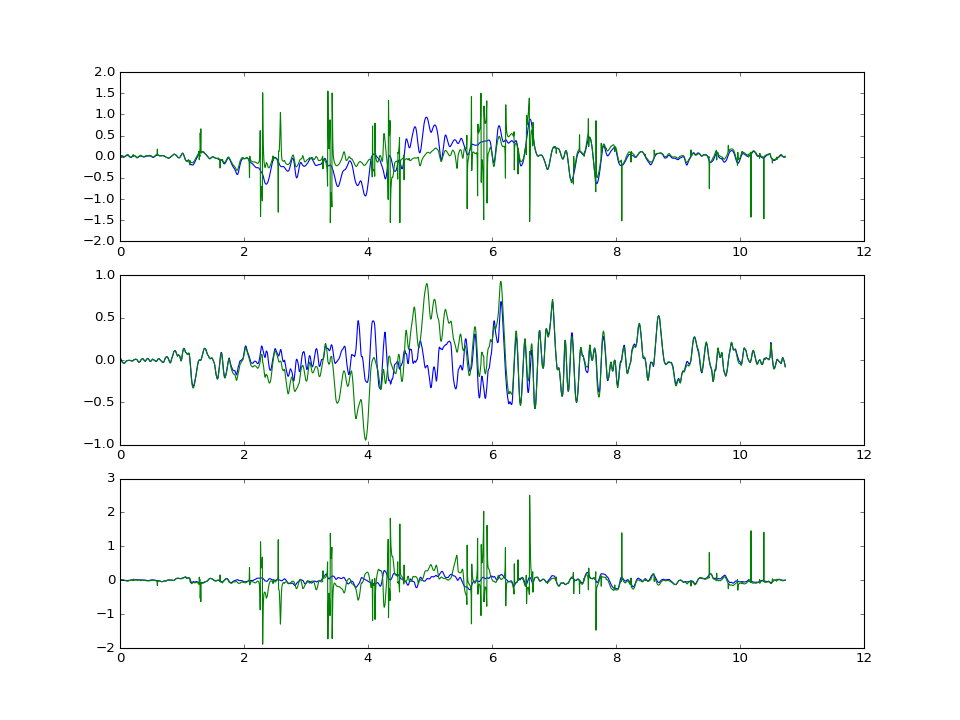

In [32]:
# align with gravity - quaternion
data_all = pandas.read_csv('../../data/test_gravity/gravity_pitch2/processed/data.csv')

ts = data_all['time'].values / nano_to_sec
ts -= ts[0]

linacce = data_all[['linacce_x', 'linacce_y', 'linacce_z']].values
linacce_stab = data_all[['linacce_stab_x', 'linacce_stab_y', 'linacce_stab_z']].values
gyro_stab = data_all[['gyro_stab_x', 'gyro_stab_y', 'gyro_stab_z']].values
gyro = data_all[['gyro_x', 'gyro_y', 'gyro_z']].values
gravity = data_all[['grav_x', 'grav_y', 'grav_z']].values

gravity_angle = np.empty(gravity.shape[0])
for i in range(gravity.shape[0]):
    gravity_angle[i] = np.dot(gravity[i], np.array([0, 1, 0]))

max_av = 2
gyro_scaled = gyro / max_av
# eular_array = np.empty(gyro.shape, dtype=np.float)
# for i in range(ts.shape[0]):
#     q = quaternion.from_euler_angles(*gyro_scaled[i])
#     eular_array[i, :] = adjust_eular_angle(quaternion.as_euler_angles(q))
# eular_array = eular_array * max_av

# plt.figure('Quaternion conversion')
# for i in range(3):
#     plt.subplot(311 + i)
#     plt.plot(ts, gyro[:, i])
#     plt.plot(ts, eular_array[:, i])
#     plt.legend(['gyro', 'reconstructed'])

local_grav_dir = np.array([0., 1., 0.])
output_euler = align_eular_rotation_with_gravity(gyro_scaled, gravity)
# output_euler = output_euler * max_av

# plt.figure('Gravity angle')
# plt.plot(ts, gravity_angle)

plt.figure('Aligned gyro (euler angle)')
for i in range(3):
    plt.subplot(311+i)
    plt.plot(ts, gyro_scaled[:, i])
    plt.plot(ts, output_euler[:, i])

<IPython.core.display.Javascript object>


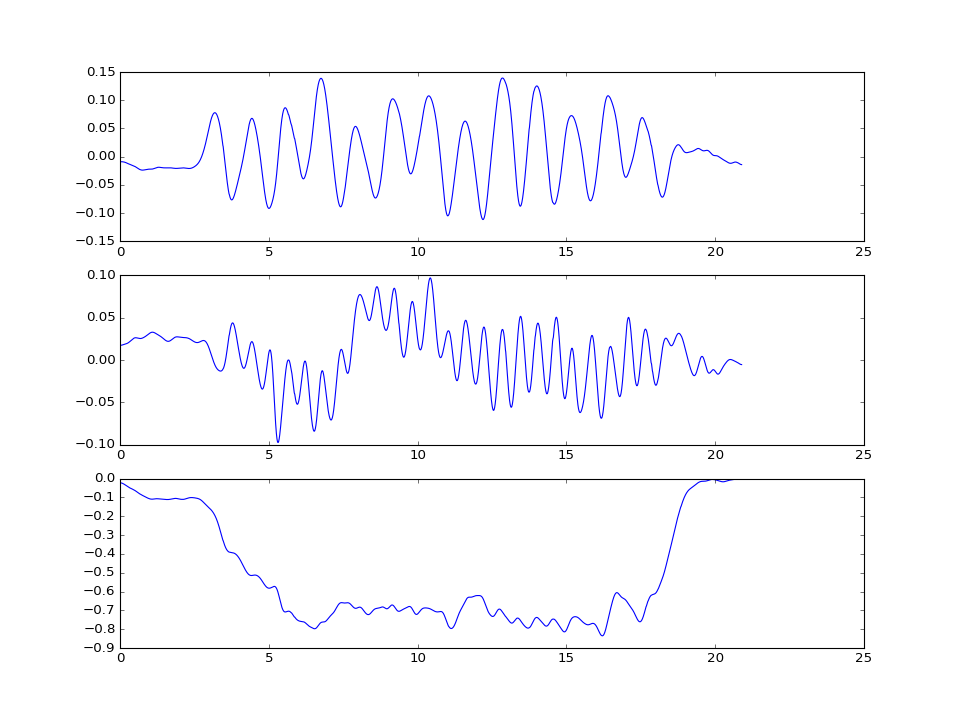

In [8]:
# smooth the speed
data_all = pandas.read_csv('../../data/test_gravity/gravity_pitch/processed/data.csv')

ts = data_all['time'].values / nano_to_sec
ts -= ts[0]

position = data_all[['pos_x', 'pos_y', 'pos_z']].values
orientation = data_all[['ori_w', 'ori_x', 'ori_y', 'ori_z']].values
gravity = data_all[['grav_x', 'grav_y', 'grav_z']].values

ls = td.compute_local_speed_with_gravity(ts, position, orientation, gravity)

filter_sigma = 20.0
ls = gaussian_filter1d(ls, sigma=filter_sigma, axis=0)
plt.figure('local speed')
for i in range(3):
    plt.subplot(311+i)
    plt.plot(ts, ls[:, i])